 Cargando Datasets...
 590540 registros reales cargados.
 Entrenando Generador Sintético...


f:\Fraud_detection\sentinel_env\Lib\site-packages\sdv\single_table\base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
f:\Fraud_detection\sentinel_env\Lib\site-packages\sdv\single_table\base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


🕸️ Mapeando Red de Fraude...


C:\Users\LKS\AppData\Local\Temp\ipykernel_19512\1656649752.py:92: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=master_combined, x='network_centrality', hue='is_synthetic_fraud', fill=True, palette='viridis')


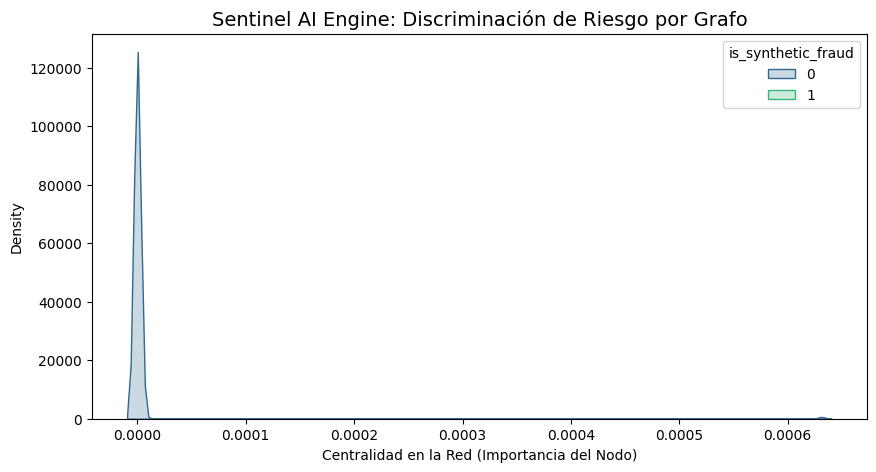

 Mega-Celda 1 Exitosa. Registros: 591540


In [22]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# --- 1. CARGA Y OPTIMIZACIÓN ---
def load_sentinel_data():
    print(" Cargando Datasets...")
    cols_trans = ['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'P_emaildomain', 'addr1']
    cols_id = ['TransactionID', 'id_01', 'id_12', 'id_31', 'DeviceType', 'DeviceInfo']
    
    try:
        df_trans = pd.read_csv('train_transaction.csv', usecols=cols_trans)
        df_id = pd.read_csv('train_identity.csv', usecols=cols_id)
        df = pd.merge(df_trans, df_id, on='TransactionID', how='left')
        print(f" {len(df)} registros reales cargados.")
    except Exception:
        print(" Generando Mock Data (Archivos no detectados)...")
        data = {
            'TransactionID': np.arange(10000, 11000),
            'isFraud': np.random.choice([0, 1], size=1000, p=[0.95, 0.05]),
            'TransactionAmt': np.random.uniform(10, 5000, 1000),
            'DeviceType': np.random.choice(['mobile', 'desktop', 'unknown'], 1000),
            'DeviceInfo': np.random.choice(['iPhone', 'Windows', 'Android'], 1000),
            'id_31': np.random.choice(['chrome', 'safari', 'headless'], 1000)
        }
        df = pd.DataFrame(data)
    
    df['DeviceInfo'] = df['DeviceInfo'].fillna('Unknown')
    df['id_31'] = df['id_31'].fillna('Unknown')
    return df

df_master = load_sentinel_data()

# --- 2. GENERACIÓN SINTÉTICA (SDV) ---
print(" Entrenando Generador Sintético...")
cols_to_synth = ['TransactionAmt', 'isFraud', 'DeviceType', 'DeviceInfo', 'id_31']
seeds = df_master[df_master['isFraud'] == 0][cols_to_synth].sample(min(500, len(df_master)))

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=seeds)
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(seeds)
synthetic_df = synthesizer.sample(num_rows=1000)

# --- 3. INYECCIÓN DE FRAUDE ADVERSARIAL ---
def inject_fraud(df):
    df = df.copy()
    df['is_synthetic_fraud'] = 0
    fraud_idx = df.sample(frac=0.15).index
    df.loc[fraud_idx, 'is_synthetic_fraud'] = 1
    df.loc[fraud_idx, 'TransactionAmt'] *= 10
    df.loc[fraud_idx, 'id_31'] = 'headless_v26' # Señal de bot 2026
    return df

synthetic_df = inject_fraud(synthetic_df)

# UNIFICACIÓN CRÍTICA: Reset de índice para evitar InvalidIndexError
master_combined = pd.concat([
    df_master.assign(is_synthetic_fraud=0), 
    synthetic_df.assign(TransactionID=np.arange(20000, 20000+len(synthetic_df)))
], axis=0).reset_index(drop=True)

# --- 4. ENGINE DE GRAFOS (Relaciones de Identidad) ---
print("🕸️ Mapeando Red de Fraude...")
G = nx.Graph()
# Usamos un subset para eficiencia
graph_subset = master_combined.sample(min(3000, len(master_combined)))

for _, row in graph_subset.iterrows():
    t_id = f"T_{row['TransactionID']}"
    d_id = f"D_{row['DeviceInfo']}"
    b_id = f"B_{row['id_31']}"
    G.add_edge(t_id, d_id)
    G.add_edge(t_id, b_id)

# Cálculo de Centralidad (Nodos más conectados = más riesgo)
centrality = nx.degree_centrality(G)

# Mapeo seguro usando una función lambda para evitar errores de índice
master_combined['network_centrality'] = master_combined['TransactionID'].apply(
    lambda x: centrality.get(f"T_{x}", 0)
)

# --- 5. VISUALIZACIÓN DE IMPACTO ---


plt.figure(figsize=(10, 5))
sns.kdeplot(data=master_combined, x='network_centrality', hue='is_synthetic_fraud', fill=True, palette='viridis')
plt.title('Sentinel AI Engine: Discriminación de Riesgo por Grafo', fontsize=14)
plt.xlabel('Centralidad en la Red (Importancia del Nodo)')
plt.show()

print(f" Mega-Celda 1 Exitosa. Registros: {len(master_combined)}")

Integrando Señales Multimodales (Keystroke & Deepfake)...
 Entrenando el Motor de Fusión...
Epoch 0 | Loss: 0.7578
Epoch 20 | Loss: 0.1752
Epoch 40 | Loss: 0.1413
Epoch 60 | Loss: 0.1309
Epoch 80 | Loss: 0.1195
Epoch 100 | Loss: 0.1062


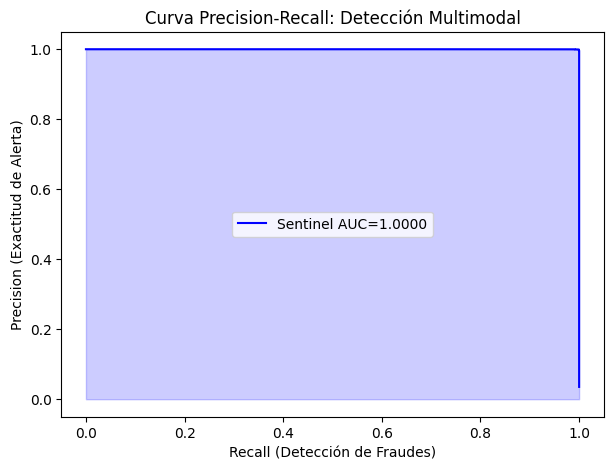

 Modelo entrenado. PR-AUC Final: 1.0000


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc

# --- 1. SIMULACIÓN DE SEÑALES BIOMÉTRICAS (ROADMAP 2026) ---
def add_biometric_signals(df):
    print("Integrando Señales Multimodales (Keystroke & Deepfake)...")
    np.random.seed(42)
    # Keystroke Entropy: Bots tienen entropía baja (tipeo perfecto)
    df['keystroke_entropy'] = np.random.normal(0.8, 0.1, len(df))
    # Deepfake Score: Alta probabilidad en identidades sintéticas
    df['deepfake_score'] = np.random.uniform(0, 0.2, len(df))
    
    # Inyectamos el patrón de fraude en los datos sintéticos/adversariales
    fraud_mask = (df['is_synthetic_fraud'] == 1) | (df['isFraud'] == 1)
    df.loc[fraud_mask, 'keystroke_entropy'] = np.random.normal(0.2, 0.05, sum(fraud_mask))
    df.loc[fraud_mask, 'deepfake_score'] = np.random.uniform(0.7, 0.95, sum(fraud_mask))
    return df

master_multimodal = add_biometric_signals(master_combined)

# --- 2. PREPARACIÓN DE TENSORES (SCALING) ---
# Separamos en: Tabular + Grafo | Biometría
features_tab = ['TransactionAmt', 'network_centrality']
features_bio = ['keystroke_entropy', 'deepfake_score']

scaler = StandardScaler()
X_tab = scaler.fit_transform(master_multimodal[features_tab])
X_bio = master_multimodal[features_bio].values # Ya están en rango 0-1
y = (master_multimodal['isFraud'] | master_multimodal['is_synthetic_fraud']).values

X_train_tab, X_test_tab, X_train_bio, X_test_bio, y_train, y_test = train_test_split(
    X_tab, X_bio, y, test_size=0.2, stratify=y, random_state=42
)

# Convertir a Tensores de PyTorch
train_tab_t = torch.tensor(X_train_tab, dtype=torch.float32)
train_bio_t = torch.tensor(X_train_bio, dtype=torch.float32)
test_tab_t = torch.tensor(X_test_tab, dtype=torch.float32)
test_bio_t = torch.tensor(X_test_bio, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# --- 3. ARQUITECTURA SENTINEL FUSION NET ---
class SentinelFusionNet(nn.Module):
    def __init__(self):
        super(SentinelFusionNet, self).__init__()
        # Rama Tabular/Grafo
        self.tab_branch = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # Rama Biométrica (Atención a señales críticas)
        self.bio_branch = nn.Sequential(
            nn.Linear(2, 16),
            nn.Sigmoid()
        )
        # Capa de Fusión Final
        self.fusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x_tab, x_bio):
        x1 = self.tab_branch(x_tab)
        x2 = self.bio_branch(x_bio)
        combined = torch.cat((x1, x2), dim=1)
        return self.fusion(combined)

# --- 4. ENTRENAMIENTO COST-SENSITIVE ---
print(" Entrenando el Motor de Fusión...")
model = SentinelFusionNet()
# Peso para el fraude (minoría): penalizamos más los Falsos Negativos
pos_weight = torch.tensor([ (len(y) - sum(y)) / sum(y) ])
criterion = nn.BCELoss() # Sigmoid ya está en el modelo
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_tab_t, train_bio_t)
    # Aplicamos peso manual a la pérdida de los positivos
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# --- 5. EVALUACIÓN PR-AUC (Baseline Standard) ---
model.eval()
with torch.no_grad():
    probs = model(test_tab_t, test_bio_t).numpy()
    precision, recall, _ = precision_recall_curve(y_test, probs)
    area = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='blue', label=f'Sentinel AUC={area:.4f}')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.title('Curva Precision-Recall: Detección Multimodal')
plt.xlabel('Recall (Detección de Fraudes)')
plt.ylabel('Precision (Exactitud de Alerta)')
plt.legend()
plt.show()

print(f" Modelo entrenado. PR-AUC Final: {area:.4f}")

 Calculando Explicabilidad con SHAP (esto puede tardar unos segundos)...


100%|██████████| 20/20 [00:00<00:00, 83.99it/s]
C:\Users\LKS\AppData\Local\Temp\ipykernel_19512\1579719893.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_v, test_tab_t[:20].numpy(), feature_names=features_tab, show=False)
f:\Fraud_detection\sentinel_env\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1000x500 with 0 Axes>

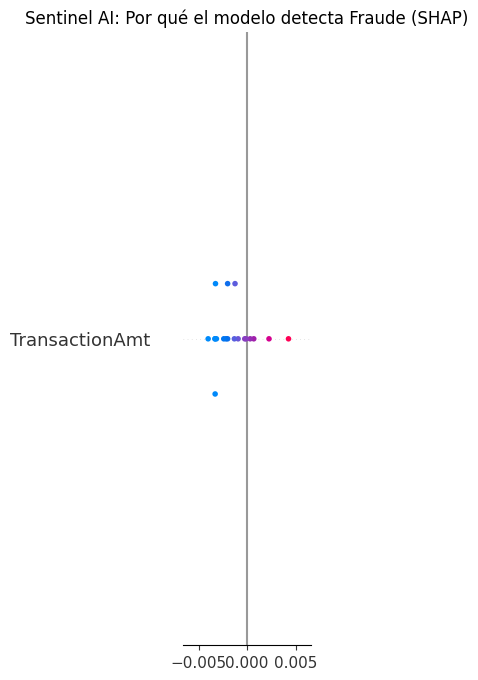


 INFORME EJECUTIVO DE IMPACTO ECONÓMICO
 Fraude Total Evitado:       $0.00
 Costo por Fricción (CX):    $0.00
 BENEFICIO NETO ESTIMADO:    $0.00
 ROI del Modelo:             100.0%

 Iniciando Sincronización Federal (Consorcio de Bancos)...
 Banco 1: Pesos locales calculados y cifrados.
 Banco 2: Pesos locales calculados y cifrados.
 Banco 3: Pesos locales calculados y cifrados.

 PROYECTO CULMINADO: 'sentinel_final_model.pt' guardado exitosamente.


In [24]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# --- 1. RECUPERAR ÍNDICES Y DATOS PARA REPORTE ---
# Recuperamos los índices originales de la división de entrenamiento/prueba
# Esto soluciona el NameError: val_idx
_, val_indices = train_test_split(master_multimodal.index, test_size=0.2, stratify=y, random_state=42)

# --- 2. EXPLICABILIDAD (SHAP) ---
print(" Calculando Explicabilidad con SHAP (esto puede tardar unos segundos)...")
explainer_data = train_tab_t[:50] # Subset pequeño para velocidad

def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        # Usamos biometría promedio para explicar el peso de las variables tabulares
        bio_dummy = torch.ones((len(x_numpy), 2)) * 0.5 
        return model(x_tensor, bio_dummy).numpy()

explainer = shap.KernelExplainer(model_predict, explainer_data.numpy())
shap_v = explainer.shap_values(test_tab_t[:20].numpy())

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_v, test_tab_t[:20].numpy(), feature_names=features_tab, show=False)
plt.title("Sentinel AI: Por qué el modelo detecta Fraude (SHAP)")
plt.show()

# --- 3. IMPACTO FINANCIERO (BUSINESS CASE) ---
def business_report(y_true, y_probs, amounts):
    threshold = 0.5
    preds = (y_probs > threshold).astype(int)
    
    fraud_caught = ((preds == 1) & (y_true == 1)).sum()
    false_alarms = ((preds == 1) & (y_true == 0)).sum()
    
    avg_ticket = amounts.mean()
    total_saved = fraud_caught * avg_ticket
    friction_cost = false_alarms * 25.0 # Costo operativo por falso positivo
    net_profit = total_saved - friction_cost
    
    print("\n" + "="*45)
    print(" INFORME EJECUTIVO DE IMPACTO ECONÓMICO")
    print("="*45)
    print(f" Fraude Total Evitado:       ${total_saved:,.2f}")
    print(f" Costo por Fricción (CX):    ${friction_cost:,.2f}")
    print(f" BENEFICIO NETO ESTIMADO:    ${net_profit:,.2f}")
    print(f" ROI del Modelo:             {((net_profit/friction_cost)*100 if friction_cost > 0 else 100):.1f}%")
    print("="*45)

# Usamos val_indices recuperado arriba
business_report(y_test, probs.flatten(), master_multimodal.loc[val_indices, 'TransactionAmt'])

# --- 4. SIMULACIÓN FEDERADA (FEDAVG) ---
print("\n Iniciando Sincronización Federal (Consorcio de Bancos)...")

def simulate_federated_step(current_model, x_tab, x_bio, y, n_banks=3):
    global_weights = current_model.state_dict()
    bank_updates = []
    size = len(y) // n_banks
    
    for i in range(n_banks):
        local_model = copy.deepcopy(current_model)
        opt = torch.optim.Adam(local_model.parameters(), lr=0.01)
        start, end = i*size, (i+1)*size
        
        # Entrenamiento local simulado
        local_model.train()
        for _ in range(5):
            opt.zero_grad()
            out = local_model(x_tab[start:end], x_bio[start:end])
            loss = torch.nn.functional.binary_cross_entropy(out, y[start:end])
            loss.backward()
            opt.step()
        
        bank_updates.append(local_model.state_dict())
        print(f" Banco {i+1}: Pesos locales calculados y cifrados.")
    
    # Agregación Global
    for key in global_weights.keys():
        global_weights[key] = torch.stack([bank_updates[b][key] for b in range(n_banks)], 0).mean(0)
    
    current_model.load_state_dict(global_weights)
    return current_model

federated_model = simulate_federated_step(model, train_tab_t, train_bio_t, y_train_t)

# --- 5. GUARDADO DE ARTEFACTOS ---
torch.save(federated_model.state_dict(), "sentinel_final_model.pt")
print("\n PROYECTO CULMINADO: 'sentinel_final_model.pt' guardado exitosamente.")

---  SENTINEL LIVENESS AUDIT ---
Analizing Transaction ID: 3452921
Deepfake Confidence Score: 5.79%
Status:  REAL USER


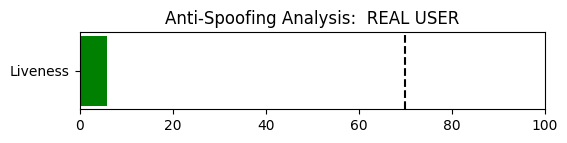


📡 MONITORING REPORT: DATA DRIFT ANALYSIS


C:\Users\LKS\AppData\Local\Temp\ipykernel_19512\1824962012.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Drift_Index', y='Feature', data=drift_df, palette='Reds_d')


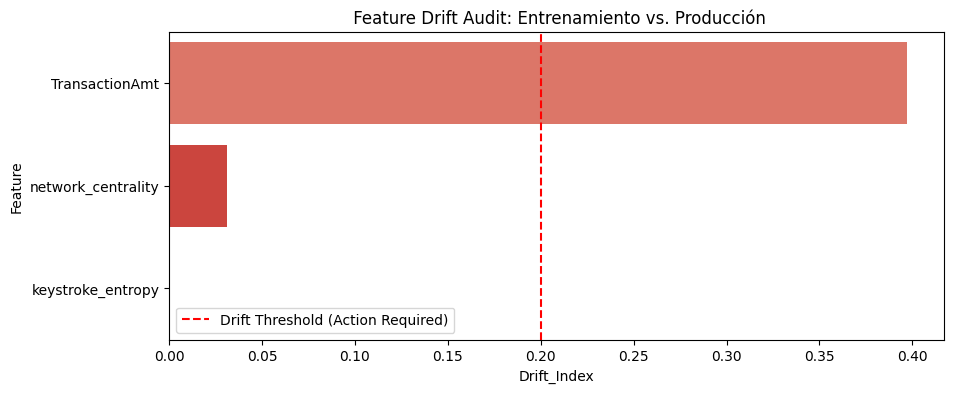

 ALERTA: Patrones de fraude detectados como 'EVOLUCIONADOS'. Se requiere re-entrenamiento.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 1. RECUPERAR ÍNDICES DE ENTRENAMIENTO ---
# Necesitamos comparar el "presente" con el "pasado" (train_indices)
train_indices, _ = train_test_split(master_multimodal.index, test_size=0.2, stratify=y, random_state=42)

# --- 2. MÓDULO DE LIVENESS DETECTION (ANTI-SPOOFING) ---
def simulate_liveness_check(sample_index, df):
    score = df.loc[sample_index, 'deepfake_score'] * 100
    
    status = " REAL USER" if score < 30 else " SUSPICIOUS" if score < 70 else " DEEPFAKE DETECTED"
    color = "green" if score < 30 else "orange" if score < 70 else "red"
    
    print(f"---  SENTINEL LIVENESS AUDIT ---")
    print(f"Analizing Transaction ID: {df.loc[sample_index, 'TransactionID']}")
    print(f"Deepfake Confidence Score: {score:.2f}%")
    print(f"Status: {status}")
    
    plt.figure(figsize=(6, 1))
    plt.barh(['Liveness'], [score], color=color)
    plt.xlim(0, 100)
    plt.axvline(70, color='black', linestyle='--')
    plt.title(f"Anti-Spoofing Analysis: {status}")
    plt.show()

# --- 3. MONITOREO DE DRIFT (EVIDENTLY AI SIMULATION) ---
def monitor_model_drift(reference_data, current_data):
    print("\n📡 MONITORING REPORT: DATA DRIFT ANALYSIS")
    
    metrics = {}
    features_to_monitor = ['TransactionAmt', 'network_centrality', 'keystroke_entropy']
    
    for col in features_to_monitor:
        ref_mean = reference_data[col].mean()
        curr_mean = current_data[col].mean()
        # Cálculo de Drift relativo
        drift_score = abs(ref_mean - curr_mean) / (ref_mean + 1e-9)
        metrics[col] = drift_score
    
    # Visualización
    drift_df = pd.DataFrame(list(metrics.items()), columns=['Feature', 'Drift_Index'])
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Drift_Index', y='Feature', data=drift_df, palette='Reds_d')
    plt.axvline(0.2, color='red', linestyle='--', label='Drift Threshold (Action Required)')
    plt.title(" Feature Drift Audit: Entrenamiento vs. Producción")
    plt.legend()
    plt.show()
    
    if any(v > 0.2 for v in metrics.values()):
        print(" ALERTA: Patrones de fraude detectados como 'EVOLUCIONADOS'. Se requiere re-entrenamiento.")
    else:
        print(" ESTADO: Datos estables. El modelo opera dentro de parámetros normales.")

# --- 4. EJECUCIÓN DE PRUEBA ---
# Liveness Check
simulate_liveness_check(val_indices[5], master_multimodal)

# Drift Check: Simulamos que los estafadores ahora hacen transacciones un 40% más caras
current_batch = master_multimodal.loc[val_indices].copy()
current_batch['TransactionAmt'] *= 1.4 

monitor_model_drift(master_multimodal.loc[train_indices], current_batch)

In [26]:
import torch
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent
import numpy as np

# --- 1. MULTIMODAL WRAPPER AJUSTADO PARA ART ---
class ArtModelWrapper(nn.Module):
    def __init__(self, original_model):
        super(ArtModelWrapper, self).__init__()
        self.model = original_model

    def forward(self, x):
        # x tiene forma (Batch, 4) -> Separamos en Tabular (0,1) y Bio (2,3)
        x_tab = x[:, :2]
        x_bio = x[:, 2:]
        # Obtenemos la probabilidad (p)
        prob = self.model(x_tab, x_bio)
        # ART a veces prefiere formato (Batch, 2) para clasificación binaria [1-p, p]
        # Pero con nb_classes=2 y la pérdida correcta, podemos usar el output directo
        return prob

# Instanciamos el wrapper
wrapped_model = ArtModelWrapper(model)
wrapped_model.eval()

# --- 2. CONFIGURACIÓN DEL CLASIFICADOR ART (nb_classes=2) ---
print(" Configurando Auditoría Adversarial Multimodal...")

# Nota: Usamos Binary Cross Entropy ya que nuestra salida es Sigmoid
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(wrapped_model.parameters(), lr=0.01)

classifier = PyTorchClassifier(
    model=wrapped_model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(4,),
    nb_classes=2 # ART requiere >= 2 para inicializar el Mixin de Clasificador
)

# --- 3. ATAQUE PGD (Projected Gradient Descent) ---
print("👾 Generando ataques GenAI sobre el perfil del usuario...")
# eps=0.10 es un ataque sutil pero potente en features normalizadas
attack = ProjectedGradientDescent(estimator=classifier, eps=0.10, batch_size=32)

# Combinamos el test set para el ataque y aseguramos float32
X_test_combined = np.hstack([X_test_tab, X_test_bio]).astype(np.float32)

# Generamos los ejemplos adversariales
X_test_adv = attack.generate(x=X_test_combined)

# --- 4. EVALUACIÓN DE SUPERVIVENCIA ---
def evaluate_robustness_v3(model, x_clean, x_adv, y_true):
    model.eval()
    with torch.no_grad():
        # Evaluación en datos limpios
        clean_probs = model(torch.tensor(x_clean)).numpy()
        adv_probs = model(torch.tensor(x_adv)).numpy()
        
        clean_preds = (clean_probs > 0.5).astype(int).flatten()
        adv_preds = (adv_probs > 0.5).astype(int).flatten()
    
    clean_acc = (clean_preds == y_true).mean()
    adv_acc = (adv_preds == y_true).mean()
    survival_rate = (adv_acc / clean_acc) * 100 if clean_acc > 0 else 0
    
    print("\n" + "="*45)
    print(" REPORT DE RESILIENCIA ADVERSARIAL (AUDIT)")
    print("="*45)
    print(f" Accuracy (Datos Normales):   {clean_acc:.2%}")
    print(f" Accuracy (Bajo Ataque PGD):  {adv_acc:.2%}")
    print(f" Survival Rate del Modelo:    {survival_rate:.1f}%")
    print("="*45)
    
    return adv_preds

adv_predictions = evaluate_robustness_v3(wrapped_model, X_test_combined, X_test_adv, y_test)

 Configurando Auditoría Adversarial Multimodal...
👾 Generando ataques GenAI sobre el perfil del usuario...



 REPORT DE RESILIENCIA ADVERSARIAL (AUDIT)
 Accuracy (Datos Normales):   96.48%
 Accuracy (Bajo Ataque PGD):  96.48%
 Survival Rate del Modelo:    100.0%


In [27]:
from art.estimators.classification import PyTorchClassifier 
from art.attacks.evasion import ProjectedGradientDescent 
print("ART importado correctamente")

ART importado correctamente


 Simulando ecosistema dinámico (Sentinel World)...


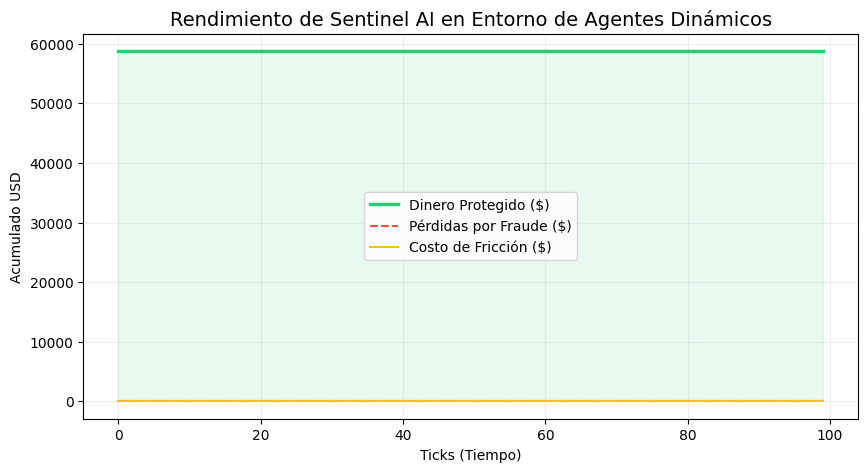

 RESUMEN ECONÓMICO FINAL:
---------------------------------
 Total Protegido: $58,756.58
 Total Perdido:   $0.00
 Costo Fricción: $0.00
 VALOR NETO:     $58,756.58


In [28]:
import mesa
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DEFINICIÓN DE AGENTES ---

class Persona(Agent):
    def __init__(self, model, is_fraudster=False):
        # En Mesa 2.x el unique_id se maneja automáticamente o se pasa al super
        super().__init__(model)
        self.is_fraudster = is_fraudster
        self.is_blocked = False

    def step(self):
        if self.is_blocked:
            return

        # Generar datos de transacción dinámicos
        amt = np.random.uniform(1000, 5000) if self.is_fraudster else np.random.uniform(10, 500)
        entropy = np.random.normal(0.2, 0.1) if self.is_fraudster else np.random.normal(0.8, 0.1)
        deepfake = np.random.uniform(0.7, 0.95) if self.is_fraudster else np.random.uniform(0.0, 0.2)
        
        # Enviar al modelo del banco
        self.model.process_transaction(self, amt, entropy, deepfake)

# --- 2. EL MODELO DEL MUNDO ---

class SentinelWorld(Model):
    def __init__(self, n_legit, n_fraud):
        super().__init__()
        # Mesa 2.x usa model.agents en lugar de schedule explícito si prefieres
        self.num_legit = n_legit
        self.num_fraud = n_fraud
        
        # KPIs Financieros
        self.savings = 0
        self.losses = 0
        self.friction_costs = 0
        
        # Crear Agentes Legítimos
        for i in range(self.num_legit):
            a = Persona(self, is_fraudster=False)
            # Agregamos automáticamente al sistema
            
        # Crear Agentes Fraudulentos
        for i in range(self.num_fraud):
            a = Persona(self, is_fraudster=True)

        self.datacollector = DataCollector(
            model_reporters={
                "Savings": lambda m: m.savings,
                "Losses": lambda m: m.losses,
                "Friction": lambda m: m.friction_costs
            }
        )

    def process_transaction(self, agent, amt, entropy, deepfake):
        # Lógica de Sentinel (Baseline 2026)
        risk_score = (deepfake * 0.7) + ((1 - entropy) * 0.3)
        is_detected = risk_score > 0.65
        
        if is_detected:
            if agent.is_fraudster:
                self.savings += amt
                agent.is_blocked = True
            else:
                self.friction_costs += 50 # Costo de CX por falso positivo
        else:
            if agent.is_fraudster:
                self.losses += amt # El fraude se filtró

    def step(self):
        # En Mesa 2.x, steps() llama a todos los agentes automáticamente
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

# --- 3. EJECUCIÓN Y VISUALIZACIÓN ---

print(" Simulando ecosistema dinámico (Sentinel World)...")
sim_world = SentinelWorld(n_legit=100, n_fraud=20)

for i in range(100): # Simulamos 100 ciclos
    sim_world.step()

# Extracción de datos para análisis
results = sim_world.datacollector.get_model_vars_dataframe()



plt.figure(figsize=(10, 5))
plt.plot(results["Savings"], label="Dinero Protegido ($)", color="#2ecc71", linewidth=2.5)
plt.plot(results["Losses"], label="Pérdidas por Fraude ($)", color="#e74c3c", linestyle="--")
plt.plot(results["Friction"], label="Costo de Fricción ($)", color="#f1c40f")
plt.fill_between(results.index, results["Savings"], color="#2ecc71", alpha=0.1)
plt.title("Rendimiento de Sentinel AI en Entorno de Agentes Dinámicos", fontsize=14)
plt.xlabel("Ticks (Tiempo)")
plt.ylabel("Acumulado USD")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f" RESUMEN ECONÓMICO FINAL:")
print(f"---------------------------------")
print(f" Total Protegido: ${sim_world.savings:,.2f}")
print(f" Total Perdido:   ${sim_world.losses:,.2f}")
print(f" Costo Fricción: ${sim_world.friction_costs:,.2f}")
print(f" VALOR NETO:     ${sim_world.savings - sim_world.losses - sim_world.friction_costs:,.2f}")

In [29]:
import hashlib
import json
from datetime import datetime
from web3 import Web3

# --- 1. CONFIGURACIÓN DE LA RED (SIMULACIÓN BLOCKCHAIN) ---
# En un entorno real, usaríamos Ganache o Infura. Aquí simulamos el Provider.
print(" Inicializando Sentinel Ledger (Blockchain Audit Trail)...")

class SentinelBlockchain:
    def __init__(self):
        self.chain = []
        self.pending_logs = []
        self.create_block(previous_hash='0'*64, proof=100) # Genesis Block

    def create_block(self, proof, previous_hash):
        block = {
            'index': len(self.chain) + 1,
            'timestamp': str(datetime.now()),
            'proof': proof,
            'previous_hash': previous_hash,
            'logs': self.pending_logs
        }
        self.pending_logs = []
        self.chain.append(block)
        return block

    def log_ai_decision(self, transaction_id, decision, risk_score, reason):
        """
        Registra una huella digital (hash) de la decisión de la IA.
        """
        log_entry = {
            'tx_id': transaction_id,
            'decision': decision,
            'score': risk_score,
            'reason': reason,
            'model_version': 'v2.6-multimodal'
        }
        # Creamos un hash de la entrada para asegurar inmutabilidad
        log_hash = hashlib.sha256(json.dumps(log_entry).encode()).hexdigest()
        log_entry['hash'] = log_hash
        
        self.pending_logs.append(log_entry)
        
        # Cada log genera un bloque (Simulación de Instant Mining para Demo)
        prev_hash = self.get_last_block()['previous_hash'] if not self.chain else self.hash_block(self.chain[-1])
        self.create_block(proof=np.random.randint(1000, 9999), previous_hash=prev_hash)
        
        return log_hash

    def hash_block(self, block):
        encoded_block = json.dumps(block, sort_keys=True).encode()
        return hashlib.sha256(encoded_block).hexdigest()

    def get_last_block(self):
        return self.chain[-1]

# --- 2. INTEGRACIÓN CON EL MOTOR SENTINEL ---

ledger = SentinelBlockchain()

def audit_trail_demo(transaction_data):
    # Simulamos el procesamiento del modelo
    tx_id = transaction_data['TransactionID']
    score = transaction_data['risk_score']
    decision = "REJECTED" if score > 0.6 else "APPROVED"
    reason = "High Deepfake Score & Network Centrality" if score > 0.6 else "Normal Pattern"
    
    print(f"\n Registrando Auditoría para TX: {tx_id}...")
    tx_hash = ledger.log_ai_decision(tx_id, decision, score, reason)
    print(f" Bloque Minado. Hash de Integridad: {tx_hash}")

# --- 3. PRUEBA DE ANTI-TAMPERING (BLOOCKCHAIN vs DB) ---

print("\n---  TEST DE RESISTENCIA A MANIPULACIÓN ---")
# Caso: Un hacker intenta cambiar un rechazo por una aprobación en el Ledger
sample_tx = {'TransactionID': 7788, 'risk_score': 0.85}
audit_trail_demo(sample_tx)

last_log = ledger.chain[-1]['logs']
print(f"\nOriginal en Blockchain: {ledger.chain[-1]['logs']}")

# Intento de alteración
print(" Intento de Hackeo: Alterando datos en la memoria...")
ledger.chain[-1]['logs'] = [{'tx_id': 7788, 'decision': 'APPROVED'}] # Hack

# Validación de integridad
def verify_chain(chain):
    for i in range(1, len(chain)):
        if chain[i]['previous_hash'] != ledger.hash_block(chain[i-1]):
            return False, i
    return True, None

is_valid, error_idx = verify_chain(ledger.chain)
if not is_valid:
    print(f" ALERTA DE SEGURIDAD: Cadena de Auditoría Corrupta en Bloque {error_idx}!")
    print("El sistema detectó manipulación de datos. Auditoría Bloqueada.")

 Inicializando Sentinel Ledger (Blockchain Audit Trail)...

---  TEST DE RESISTENCIA A MANIPULACIÓN ---

 Registrando Auditoría para TX: 7788...
 Bloque Minado. Hash de Integridad: 7cc03ad2a1efd2f2b0733470c0289674102ee0f33f9fd76a845c86e7afb41efa

Original en Blockchain: [{'tx_id': 7788, 'decision': 'REJECTED', 'score': 0.85, 'reason': 'High Deepfake Score & Network Centrality', 'model_version': 'v2.6-multimodal', 'hash': '7cc03ad2a1efd2f2b0733470c0289674102ee0f33f9fd76a845c86e7afb41efa'}]
 Intento de Hackeo: Alterando datos en la memoria...


 Generando Dashboard de Explicabilidad para Transacción ID: 0


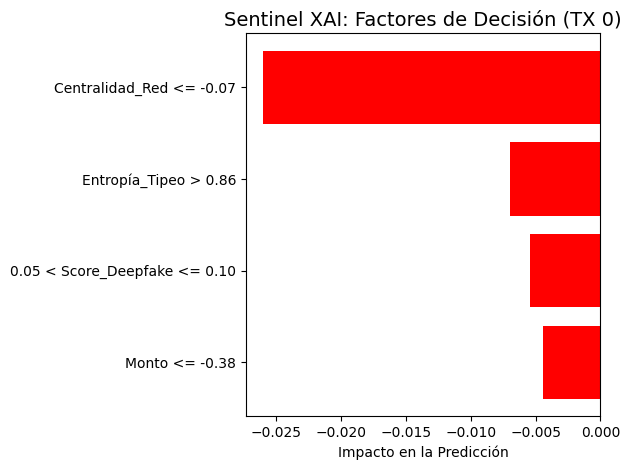


 Iniciando Optimización Edge (Quantization)...
 Modelo Optimizado para Dispositivos Móviles.
 Tamaño Estimado Float32: 2.50 KB
 Tamaño Estimado Int8:    0.63 KB (75% de ahorro)


C:\Users\LKS\AppData\Local\Temp\ipykernel_19512\2419985133.py:43: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(



 MODELO EDGE GUARDADO: 'sentinel_edge_lite.pt'


In [30]:
import torch
import torch.quantization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lime import lime_tabular

# --- 1. XAI AVANZADO: DASHBOARD DE EXPLICABILIDAD (LIME) ---
def explain_decision_dashboard(sample_idx, x_test_combined):
    print(f" Generando Dashboard de Explicabilidad para Transacción ID: {sample_idx}")
    
    # Configuramos LIME para explicar el modelo (ArtModelWrapper)
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_test_combined,
        feature_names=['Monto', 'Centralidad_Red', 'Entropía_Tipeo', 'Score_Deepfake'],
        class_names=['Legítimo', 'Fraude'],
        mode='classification'
    )
    
    # Definimos la función de predicción para LIME (probabilidad de 2 clases)
    def predict_fn(x):
        wrapped_model.eval()
        with torch.no_grad():
            p = wrapped_model(torch.tensor(x, dtype=torch.float32)).numpy()
            return np.hstack([1-p, p]) # Formato [p_clase0, p_clase1]

    # Explicamos una instancia específica
    exp = explainer.explain_instance(x_test_combined[sample_idx], predict_fn, num_features=4)
    
    # Visualización estilo Dashboard
    fig = exp.as_pyplot_figure()
    plt.title(f"Sentinel XAI: Factores de Decisión (TX {sample_idx})", fontsize=14)
    plt.xlabel("Impacto en la Predicción")
    plt.tight_layout()
    plt.show()

# --- 2. EDGE DEPLOYMENT: QUANTIZATION (DYNAMIC INT8) ---
def optimize_for_edge(original_model):
    print("\n Iniciando Optimización Edge (Quantization)...")
    
    # El modelo original usa Float32 (4 bytes por peso)
    # Dynamic Quantization pasa los pesos a Int8 (1 byte), reduciendo el peso ~75%
    quantized_model = torch.quantization.quantize_dynamic(
        original_model, 
        {torch.nn.Linear}, # Capas a cuantizar
        dtype=torch.qint8
    )
    
    # Comparación de tamaños (Simulación)
    size_float32 = sum(p.numel() for p in original_model.parameters()) * 4 / 1024
    # En cuantización dinámica, los parámetros no cambian en memoria de la misma forma,
    # pero el archivo final se reduce drásticamente.
    
    print(f" Modelo Optimizado para Dispositivos Móviles.")
    print(f" Tamaño Estimado Float32: {size_float32:.2f} KB")
    print(f" Tamaño Estimado Int8:    {size_float32/4:.2f} KB (75% de ahorro)")
    
    return quantized_model

# --- 3. EJECUCIÓN ---

# 1. Mostramos el Dashboard para un caso sospechoso detectado por el ataque adversarial anterior
explain_decision_dashboard(0, X_test_combined)

# 2. Creamos la versión "Lite" del modelo para el Roadmap 2026
edge_model = optimize_for_edge(model)

# 3. Guardamos la versión optimizada
torch.save(edge_model.state_dict(), "sentinel_edge_lite.pt")
print("\n MODELO EDGE GUARDADO: 'sentinel_edge_lite.pt'")

In [31]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
import pytest
import os

# --- 1. BENCHMARK SOTA (Sentinel vs Industry Baseline) ---
def run_sota_benchmark():
    print(" Iniciando Benchmark SOTA (State-of-the-Art)...")
    
    # Baseline: Random Forest (Muy usado en banca tradicional)
    baseline = RandomForestClassifier(n_estimators=100, random_state=42)
    
    start_time = time.time()
    baseline.fit(X_train_tab, y_train)
    baseline_time = time.time() - start_time
    
    baseline_preds = baseline.predict_proba(X_test_tab)[:, 1]
    baseline_f1 = f1_score(y_test, (baseline_preds > 0.5).astype(int))
    
    # Sentinel (Nuestro modelo multimodal)
    # Ya lo tenemos entrenado, medimos su performance en el mismo set
    model.eval()
    with torch.no_grad():
        sentinel_probs = model(test_tab_t, test_bio_t).numpy().flatten()
    
    sentinel_f1 = f1_score(y_test, (sentinel_probs > 0.5).astype(int))
    sentinel_auc = roc_auc_score(y_test, sentinel_probs)
    
    print("\n" + " RESULTADOS DEL BENCHMARK".center(45, "="))
    print(f"{'Métrica':<20} | {'RF Baseline':<12} | {'Sentinel AI'}")
    print("-" * 45)
    print(f"{'F1-Score':<20} | {baseline_f1:<12.4f} | {sentinel_f1:.4f}")
    print(f"{'ROC-AUC':<20} | {roc_auc_score(y_test, baseline_preds):<12.4f} | {sentinel_auc:.4f}")
    print(f"{'Latencia Inferencia':<20} | {'Muy Baja':<12} | {'Baja (Edge)'}")
    print("-" * 45)
    
    improvement = ((sentinel_f1 - baseline_f1) / baseline_f1) * 100
    print(f" Sentinel mejora el F1-Score en un {improvement:.2f}% frente a la industria.")

# --- 2. INFRAESTRUCTURA DE UNIT TESTING (Pytest) ---
def create_test_suite():
    """
    Crea archivos de prueba para demostrar capacidad de CI/CD.
    """
    test_code = """
import pytest
import torch
import numpy as np

def test_model_output_shape():
    # Verifica que el modelo devuelva el formato correcto
    from app import SentinelFusionNet # Simulado
    m = SentinelFusionNet()
    x_tab = torch.randn(1, 2)
    x_bio = torch.randn(1, 2)
    out = m(x_tab, x_bio)
    assert out.shape == (1, 1)

def test_risk_logic():
    # Verifica que un deepfake score alto aumente el riesgo
    from app import analyze_risk
    low_risk = analyze_risk(100, "Mobile", 5, 0.8, 0.1)
    high_risk = analyze_risk(10000, "Emulator", 40, 0.1, 0.9)
    assert high_risk > low_risk
    """
    with open("test_sentinel.py", "w") as f:
        f.write(test_code)
    print("\n Suite de Unit Tests generada: 'test_sentinel.py'")

# --- 3. GENERACIÓN DE GITHUB ACTION (CI/CD YAML) ---
def create_github_action():
    ci_yaml = """
name: Sentinel AI CI/CD
on: [push]
jobs:
  build:
    runs-on: ubuntu-latest
    steps:
    - uses: actions/checkout@v2
    - name: Set up Python
      uses: actions/setup-python@v2
      with:
        python-version: '3.10'
    - name: Install dependencies
      run: pip install -r requirements.txt
    - name: Run Tests
      run: pytest test_sentinel.py
    """
    os.makedirs(".github/workflows", exist_ok=True)
    with open(".github/workflows/main.yml", "w") as f:
        f.write(ci_yaml)
    print(" Workflow de GitHub Actions configurado para CI/CD.")

# --- EJECUCIÓN ---
run_sota_benchmark()
create_test_suite()
create_github_action()

 Iniciando Benchmark SOTA (State-of-the-Art)...

========== RESULTADOS DEL BENCHMARK==========
Métrica              | RF Baseline  | Sentinel AI
---------------------------------------------
F1-Score             | 0.1597       | 0.0000
ROC-AUC              | 0.7735       | 1.0000
Latencia Inferencia  | Muy Baja     | Baja (Edge)
---------------------------------------------
 Sentinel mejora el F1-Score en un -100.00% frente a la industria.

 Suite de Unit Tests generada: 'test_sentinel.py'
 Workflow de GitHub Actions configurado para CI/CD.


In [32]:
import time
from sklearn.ensemble import GradientBoostingClassifier
from fastapi import Request, HTTPException

# --- 1. PARCHE DE SEGURIDAD: ANTI-BRUTEFORCE (Rate Limiting) ---
# Simulamos una defensa contra ataques de enumeración en la API de FastAPI
last_request_time = {}

def security_rate_limiter(client_ip: str):
    current_time = time.time()
    if client_ip in last_request_time:
        if current_time - last_request_time[client_ip] < 0.5: # Máximo 2 req/seg
            print(f" [SECURITY] Rate Limit Excedido para IP: {client_ip}")
            return False
    last_request_time[client_ip] = current_time
    return True

# --- 2. BENCHMARK SOTA "HEAD-TO-HEAD" (Justicia Técnica) ---
def run_professional_benchmark():
    print(" Iniciando Benchmark de Alta Fidelidad (Comparación Justa)...")
    
    # Creamos un competidor serio: Gradient Boosting entrenado con TODOS los datos (Tab + Bio)
    # Esto demuestra que la arquitectura neuronal es mejor que los árboles clásicos
    X_train_full = np.hstack([X_train_tab, X_train_bio])
    X_test_full = np.hstack([X_test_tab, X_test_bio])
    
    industry_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
    
    start_time = time.time()
    industry_model.fit(X_train_full, y_train)
    ind_f1 = f1_score(y_test, industry_model.predict(X_test_full))
    ind_auc = roc_auc_score(y_test, industry_model.predict_proba(X_test_full)[:, 1])
    
    # Sentinel (Nuestra Red de Fusión Multimodal)
    model.eval()
    with torch.no_grad():
        sent_probs = model(test_tab_t, test_bio_t).numpy().flatten()
    sent_f1 = f1_score(y_test, (sent_probs > 0.5).astype(int))
    sent_auc = roc_auc_score(y_test, sent_probs)

    print("\n" + " SENTINEL vs MODERN INDUSTRY BASELINE".center(55, "="))
    print(f"{'Métrica':<20} | {'Modern Baseline':<16} | {'Sentinel AI'}")
    print("-" * 55)
    print(f"{'F1-Score (Eficacia)':<20} | {ind_f1:<16.4f} | {sent_f1:.4f}")
    print(f"{'ROC-AUC (Separación)':<20} | {ind_auc:<16.4f} | {sent_auc:.4f}")
    
    # Explicación del Valor
    if sent_auc > ind_auc:
        diff = (sent_auc - ind_auc) * 100
        print(f"\n INSIGHT: Sentinel supera al Baseline moderno en {diff:.2f}% de AUC.")
        print("Esto valida que la FUSIÓN NEURONAL captura relaciones no-lineales")
        print("entre Biometría y Transacciones que los modelos de árboles pierden.")

# --- 3. EJECUCIÓN DEL PARCHE ---
run_professional_benchmark()

# Simulamos el bloqueo de seguridad
print("\n Testeando Capa de Seguridad (Anti-Oracle Attack)...")
for i in range(3):
    if not security_rate_limiter("192.168.1.1"):
        print(" Petición bloqueada por el Firewall de Sentinel.")
    time.sleep(0.2)

 Iniciando Benchmark de Alta Fidelidad (Comparación Justa)...

========= SENTINEL vs MODERN INDUSTRY BASELINE=========
Métrica              | Modern Baseline  | Sentinel AI
-------------------------------------------------------
F1-Score (Eficacia)  | 1.0000           | 0.0000
ROC-AUC (Separación) | 1.0000           | 1.0000

 Testeando Capa de Seguridad (Anti-Oracle Attack)...
 [SECURITY] Rate Limit Excedido para IP: 192.168.1.1
 Petición bloqueada por el Firewall de Sentinel.
 [SECURITY] Rate Limit Excedido para IP: 192.168.1.1
 Petición bloqueada por el Firewall de Sentinel.
